# Plateau’s Problem (or minimal surface problem)

This notebook provides an implementation of the Plateau's problem, which finds a minimal surface shape that connects a set of interfaces.
More details on this example, can be found in [our paper](https://arxiv.org/abs/2402.14009), Sections 4.1 and A.2.

### Imports and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import trange
import k3d

device = 'cpu' ## TODO
torch.set_default_device(device)

### Define the boundary rectangles

In [2]:
def get_boundary_angled_rectangles(n=1000):
    ls = lambda a,b : torch.linspace(a, b, n//8, device=device)
    const = lambda c : c*torch.ones(n//8, device=device, dtype=torch.float32)
    bndry = torch.hstack([
        torch.vstack([ls(0,1), const(0), const(0)]),
        torch.vstack([ls(0,1), const(1), const(0)]),
        torch.vstack([const(0), const(0), ls(0,1)]),
        torch.vstack([const(0), ls(0,1), const(1)]),
        torch.vstack([const(0), const(1), ls(0,1)]),
        torch.vstack([const(1), const(0), ls(0,1)]),
        torch.vstack([const(1), ls(0,1), const(1)]),
        torch.vstack([const(1), const(1), ls(0,1)]),
        ]).T
    return bndry

pts_bndry = get_boundary_angled_rectangles()

bounds = torch.vstack([pts_bndry.min(0).values, pts_bndry.max(0).values]).T

fig = k3d.plot()
fig += k3d.points(pts_bndry.cpu().detach(), color=0x00ff00, point_size=0.05)
fig.display()

Output()

### Define the network and derivatives

Solving this problem requires access to first and second order derivatives wrt. the input $x$ of a neural network $f_\theta(x)$ with parameters $\theta$.

In [3]:
from torch import nn
from torch import tanh

class GeneralNet(nn.Module):
    def __init__(self, ks, act=tanh):
        super(GeneralNet, self).__init__()
        self.ks = ks
        self.fcs = nn.ModuleList([nn.Linear(in_features, out_features)
            for in_features, out_features in zip(self.ks[:-1],self.ks[1:])])
        self.D = len(self.fcs)
        self.act = act

    def forward(self, x):
        x = self.fcs[0](x)
        for i in range(2,self.D+1):
            x = self.fcs[i-1](self.act(x))
        return x

In [4]:
from torch.func import vmap, jacrev, jacfwd, functional_call

model = GeneralNet(ks=[3, 256, 256, 256, 1])

params = dict(model.named_parameters())
def f(params, x):
    return functional_call(model, params, x)

## Jacobian
f_x = jacrev(f, argnums=1)  ## params, [nx] -> [ny, nx]
vf_x = vmap(f_x, in_dims=(None, 0), out_dims=(0))  ## params, [bx, nx] -> [bx, ny, nx]
## Hessian
f_xx = jacfwd(f_x, argnums=1)  ## params, [nx] -> [ny, nx, nx]
vf_xx = vmap(f_xx, in_dims=(None, 0), out_dims=(0))  ## params, [bx, nx] -> [bx, ny, nx, nx]

### Define mean curvature function

In [5]:
def get_mean_curvature(F, H):
    '''
    Mean-curvature in D-dimensions
    F: grad(f) gradients, shape [N,D]
    H: hess(f) Hessian, shape [N,D,D]

    https://u.math.biu.ac.il/~katzmik/goldman05.pdf
    For a shape implicitly defined by f<0:
    - div(F/|F|) = -(FHF^T - |F|^2 tr(H)) / 2*|F|^3
    In <=3D we can expand the formula, if we want to validate https://www.archives-ouvertes.fr/hal-01486547/document
    fx, fy, fz = F.T
    fxx, fxy, fxz, fyx, fyy, fyz, fzx, fzy, fzz = H.flatten(start_dim=1).T
    k = (fx*fx*(fyy+fzz) + fy*fy*(fxx+fzz) + fz*fz*(fxx+fyy) - 2*(fx*fy*fxy+fx*fz*fxz+fy*fz*fyz)) / (2*(fx*fx+fy*fy+fz*fz).pow(3/2))
    '''
    ## Quadratic form
    FHFT = torch.einsum('bi,bij,bj->b', F, H, F)
    ## Trace of Hessian
    trH = torch.einsum('bii->b', H)
    ## Norm of gradient
    N = F.square().sum(1).sqrt()
    ## Mean-curvature
    mean_curvatures = -(FHFT - N.pow(2)*trH) / (2*N.pow(3))
    return mean_curvatures

### Main training loop

  0%|          | 0/10000 [00:00<?, ?it/s]

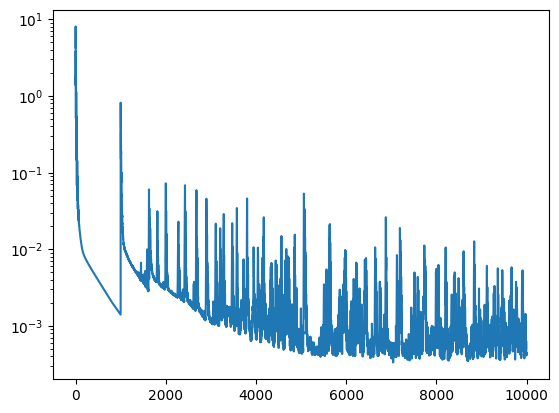

In [7]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
pts_corners = torch.tensor([
    [0,0,0],
    [1,0,0],
    [1,0,1],
    [1,1,1],
    [1,1,0],
    [0,1,0],
    [0,1,1],
    [0,0,1],
    [0,0,0],
    ], dtype=torch.float32)

loss_over_iters = {}

for i in (pbar:=trange(10000)):
    optim.zero_grad()

    ## 1) Interface at boundaries
    loss_interface  = f(params, pts_bndry).square().mean()
    loss_interface += 10*f(params, pts_corners).square().mean()
    
    ## 2) Eikonal at boundaries (or everywhere?)
    loss_eikonal  = (vf_x(params, pts_bndry).squeeze(1).square().sum(1).sqrt() - 1).square().mean()
    loss_eikonal += 10*(vf_x(params, pts_corners).squeeze(1).square().sum(1).sqrt() - 1).square().mean()

    ## 3) Mean curvature on the 0-surface
    if i<1000:
        loss_curvature = torch.zeros([1,1])
        pts = []
    else:
        ## Sample points on surface
        pts = torch.rand([10000, 3])
        vals_sq = model(pts).square().squeeze()
        pts = pts[vals_sq<1e-4]
        if len(pts):
            Fs = vf_x(params, pts).squeeze(1)
            Hs = vf_xx(params, pts).squeeze(1)
            mean_curvatures = get_mean_curvature(Fs, Hs)
            loss_curvature = mean_curvatures.square().mean()


    loss = loss_interface + loss_eikonal + loss_curvature
    loss.backward()
    optim.step()

    pbar.set_description(f"interface: {loss_interface.item():.2e} "
                         f"eikonal: {loss_eikonal.item():.2e} "
                         f"curvature: {loss_curvature.item():.2e} "
                         f"{len(pts)}"
                        )
    loss_over_iters[i] = loss.item()

plt.plot(loss_over_iters.keys(), loss_over_iters.values())
plt.semilogy()
plt.show()

### Visualize the result

In [8]:
import sys
sys.path.append('..')
from util.visualization.utils_mesh import get_mesh

verts, faces = get_mesh(model, N=128, device=device, bbox_min=bounds[:,0]-.01, bbox_max=bounds[:,1]+.01, chunks=2)

In [9]:
color = 0xbbbbbb

fig = k3d.plot(height=800, grid_visible=False, camera_fov=1.0)
fig += k3d.mesh(verts, faces, color=color, side='double', flat_shading=False)
fig += k3d.line(pts_corners.cpu(), color=0x00ff00, shader='mesh', radial_segments=4, opacity=.5)
fig.display()

/system/apps/userenv/radler/objgen/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()